# Loading Data

In [25]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import defaultdict, Counter
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /Users/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/dev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/dev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def plot_donut(df, review_text_col, is_spoiler_col, df_name): 
    counts = df[is_spoiler_col].value_counts().values
    labels = df[is_spoiler_col].value_counts().index
    total_count = counts.sum()

    label_map = {0: 'Not Spoiler', 1: 'Spoiler'}
    descriptive_labels = [label_map[i] for i in labels]

    def make_autopct(values):
        def my_autopct(pct):
            val = int(round(pct * total_count / 100.0))
            return f'{pct:.1f}%\n({val:,d})'
        return my_autopct
    
    explode = (0.05, 0.05) 
    plt.figure(figsize=(8, 8))
    plt.pie(counts, 
            labels=descriptive_labels, 
            autopct=make_autopct(counts),
            pctdistance=0.85,
            startangle=90, 
            explode=explode)

    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(f'Distribution of Spoiler vs. Non-Spoiler Reviews {df_name}') 
    plt.show()

def plot_publishing_date(df, publishe_date_col, df_name): 
    review_counts = df.set_index(publishe_date_col).resample('M').size()

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    review_counts.plot(
        kind='line',
        color='teal',
        linewidth=2.0,
        marker='o',
        markersize=4
    )

    plt.title(f'Number of Reviews Published Over Time (Monthly Count) {df_name}', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Date of Review', fontsize=12)
    plt.ylabel('Number of Reviews (Count)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show() 

def plot_text_distribution(df, review_text_col, is_spoiler_col, df_name): 
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    df[review_text_col].str.len().hist(
        bins=20, 
        color='#1f77b4', 
        edgecolor='black',
        alpha=0.8 
    )
    plt.title(f'Distribution of Review Text Lengths {df_name}', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Text Length (Number of Characters)', fontsize=12, labelpad=10)
    plt.ylabel('Frequency (Count of Reviews)', fontsize=12, labelpad=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(top=True, right=True)
    plt.tight_layout() 
    plt.show()

def plot_word_distribution(df, review_text_col, is_spoiler_col, df_name): 
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    words_text = df[review_text_col].str.split().map(lambda x: len(x))
    words_text.hist(
        bins=20, 
        color='#1f77b4', 
        edgecolor='black',
        alpha=0.8 
    )
    plt.title(f'Distribution of Review Word Count {df_name}', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Word Count (Number of Words)', fontsize=12, labelpad=10)
    plt.ylabel('Frequency (Count of Reviews)', fontsize=12, labelpad=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(top=True, right=True)
    plt.tight_layout() 
    plt.show()

    print("Total amount of words in df: ", words_text.sum())

def punctuations_lower_tokenize_dataframe(df, review_text_col, is_spoiler_col, df_name): 
    def punctuations_lower_tokenize(text): 
        # clear puntuations, lowe, tokenize
        text = re.sub(r'[^\w\s]', '', str(text).lower())
        words = word_tokenize(text)

        return words

    df['punctuations_lower_tokenize'] = df[review_text_col].apply(punctuations_lower_tokenize)
    return df

def stopwords_lemmatization(df):

    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN 
    global id
    id = 0

    def extract_analysis(words, lemmatizer):
        global id
        id += 1
        if (id % 10000 == 0): print(f"Transformed rows: {id}")
        pos_tagged_words = nltk.pos_tag(words)
        stops = [word for word in words if word in stop_words]
        stops_count = len(stops)
        total_word_count = len(words)

        content_words = []
        for word, tag in pos_tagged_words: 
            if word in stop_words or len(word) <= 1:
                continue
            wntag = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, wntag)
            content_words.append(lemma)

        return stops, stops_count, total_word_count, content_words

    lemmatizer = WordNetLemmatizer()
    df[['stops', 'stopword_count', 'total_word_count', 'content_words']]  = df['punctuations_lower_tokenize'].apply(
        lambda x: pd.Series(extract_analysis(x, lemmatizer))
    )
    return df

def plot_stopwords(df, df_name): 
    all_stopwords = df['stops'].explode().tolist()
    all_stopwords = [word for word in all_stopwords if isinstance(word, str)] 

    stopword_freq = Counter(all_stopwords)

    N = 20
    most_common_stopwords = stopword_freq.most_common(N)

    words, counts = zip(*most_common_stopwords)

    ratio = df['stopword_count'].sum()/df['total_word_count'].sum()*100
    print(f'Percentage of stopwords in reviews: {ratio:.2f}%')

    plt.figure(figsize=(12, 7))
    plt.bar(words, counts, color='skyblue')
    plt.title(f'Top {N} Most Frequent Stop Words {df_name}')
    plt.xlabel('Stop Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_content_words(all_content_words, df_name): 

    word_freq = Counter(all_content_words)

    N = 20
    most_common_words = word_freq.most_common(N)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(12, 7))
    plt.bar(words, counts, color='teal')
    plt.title(f'Top {N} Most Frequent Non-Stop Words (Content Words) {df_name}')
    plt.xlabel('Content Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90, ha='right') 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_wordcloud(all_content_words, df_name):
    def show_wordcloud(data):
        wordcloud = WordCloud(
            background_color='white',
            stopwords=stop_words,
            max_words=100,
            max_font_size=30,
            scale=3,
            random_state=1)

        wordcloud=wordcloud.generate(str(data))

        fig = plt.figure(1, figsize=(12, 12))
        plt.axis('off')
        plt.title(f"Wordcloud for {df_name}")

        plt.imshow(wordcloud)
        plt.show()

    show_wordcloud(" ".join(all_content_words))

def do_eda(df, review_text_col, is_spoiler_col, publishe_date_col, df_name): 
    plot_donut(df, review_text_col, is_spoiler_col, df_name)
    plot_publishing_date(df, publishe_date_col, df_name)
    plot_text_distribution(df, review_text_col, is_spoiler_col, df_name)
    plot_word_distribution(df, review_text_col, is_spoiler_col, df_name)
    df = punctuations_lower_tokenize_dataframe(df, review_text_col, is_spoiler_col, df_name)
    df = stopwords_lemmatization(df)
    plot_stopwords(df, df_name)
    all_content_words = df['content_words'].explode().tolist()    
    all_content_words = [word for word in all_content_words if isinstance(word, str)]

    plot_content_words(all_content_words, df_name)
    plot_wordcloud(all_content_words, df_name)
    return df
    

## IMDB

In [27]:
file_name = 'IMDB_reviews.json'
file_path = f'./data/{file_name}'

imdb_df = pd.read_json(file_path, lines=True)
imdb_df['review_date'] = pd.to_datetime(imdb_df['review_date'], format='%d %B %Y', errors='coerce')
imdb_df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,2006-02-10,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,2000-09-06,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,2001-08-03,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,2002-09-01,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,2004-05-20,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [28]:
print("Dataframe shape before sampling: ", imdb_df.shape)
imdb_df = imdb_df.sample(n=50_000, random_state=42)
print("Dataframe shape after sampling: ", imdb_df.shape)


Dataframe shape before sampling:  (573913, 7)
Dataframe shape after sampling:  (50000, 7)


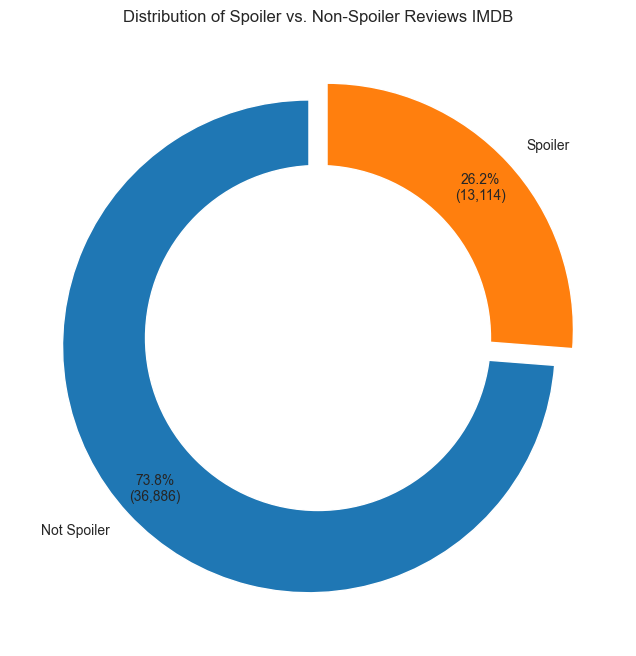

/var/folders/hr/ymtxctgs4jj0mr96r616g73r0000gp/T/ipykernel_7977/2590002882.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_counts = df.set_index(publishe_date_col).resample('M').size()


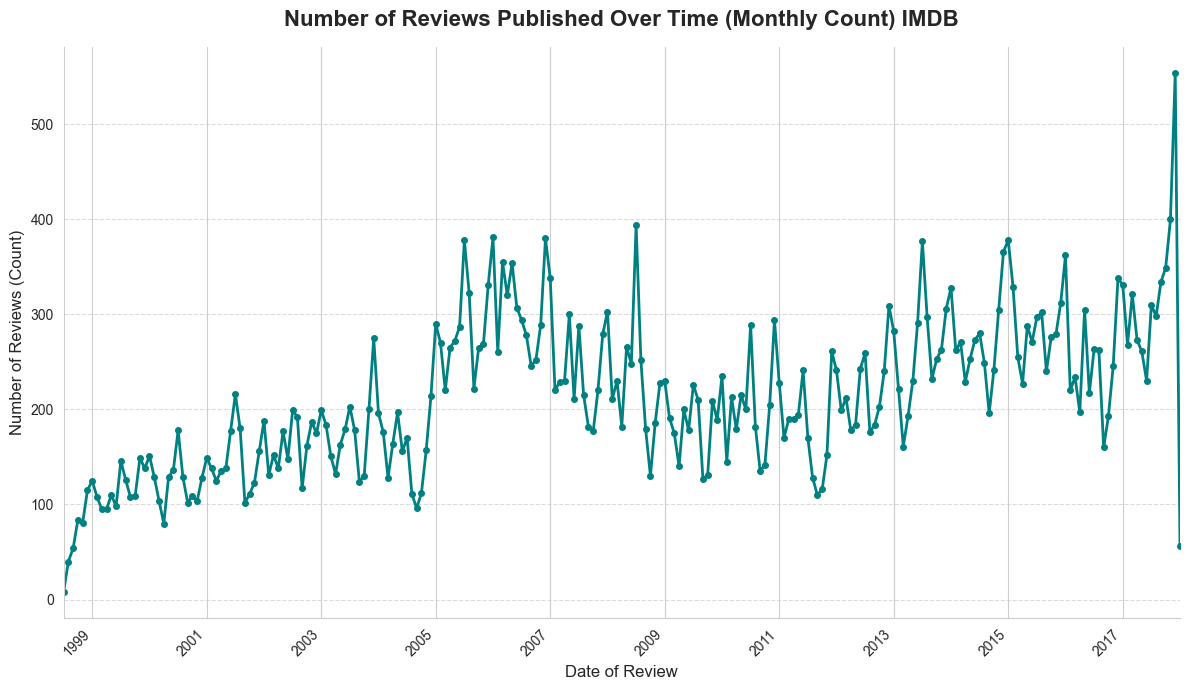

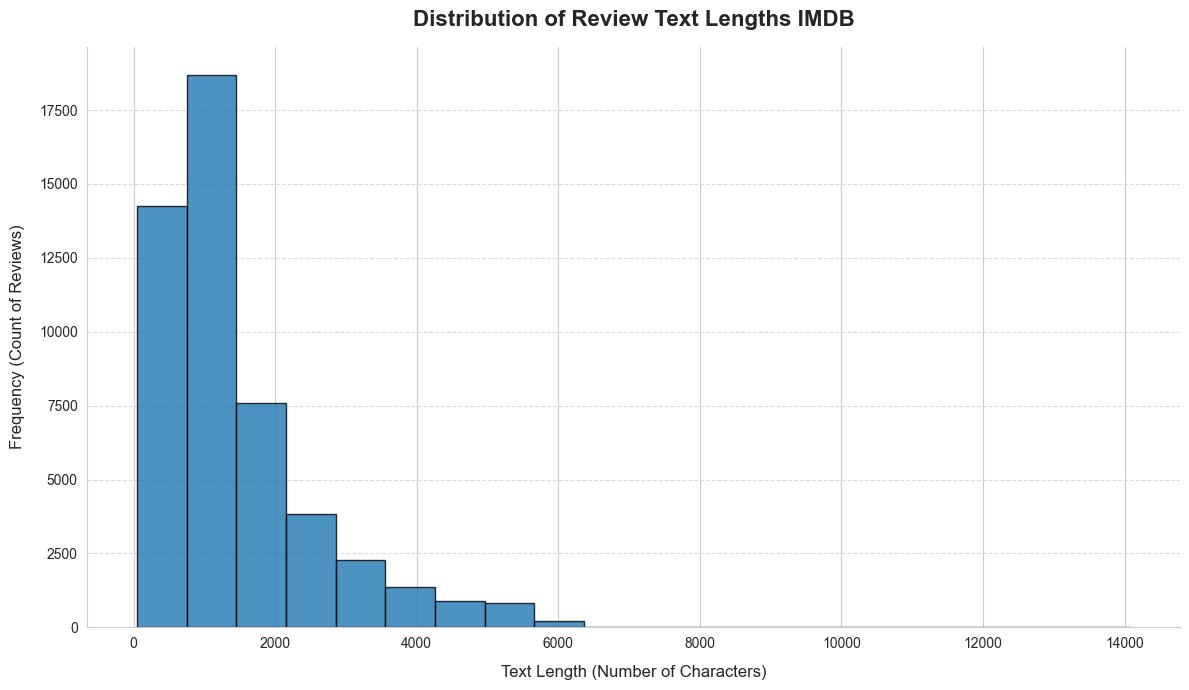

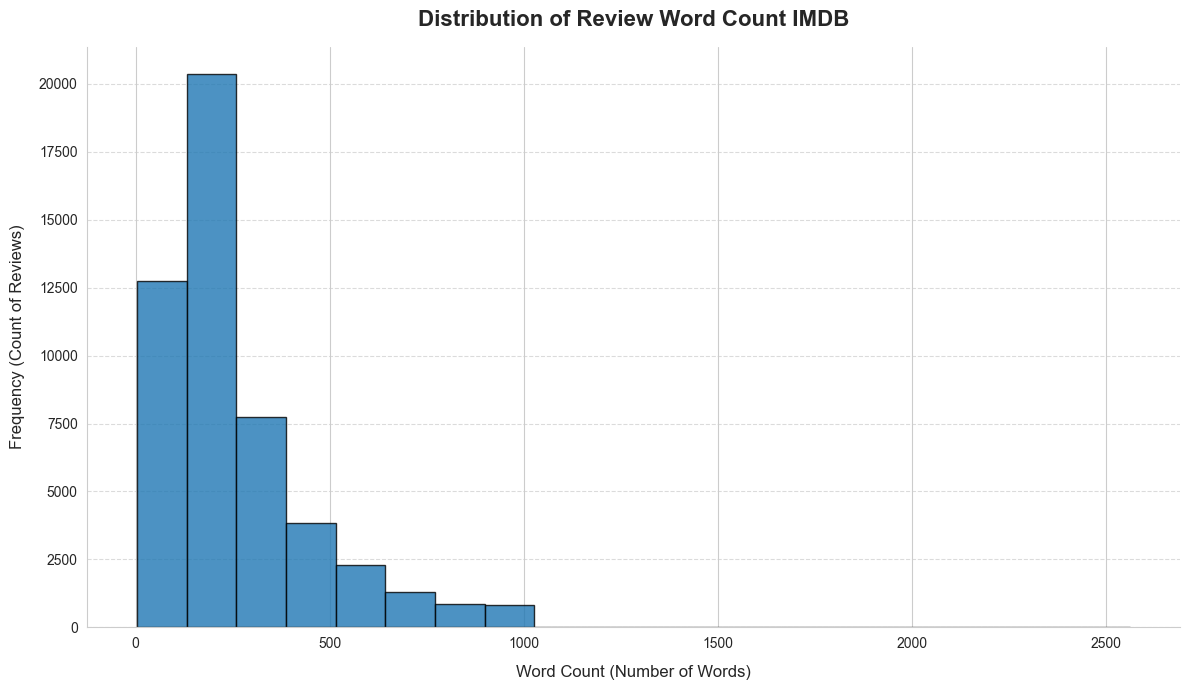

Total amount of words in df:  12904479
Transformed rows: 10000
Transformed rows: 20000
Transformed rows: 30000
Transformed rows: 40000
Transformed rows: 50000
Percentage of stopwords in reviews: 47.51%


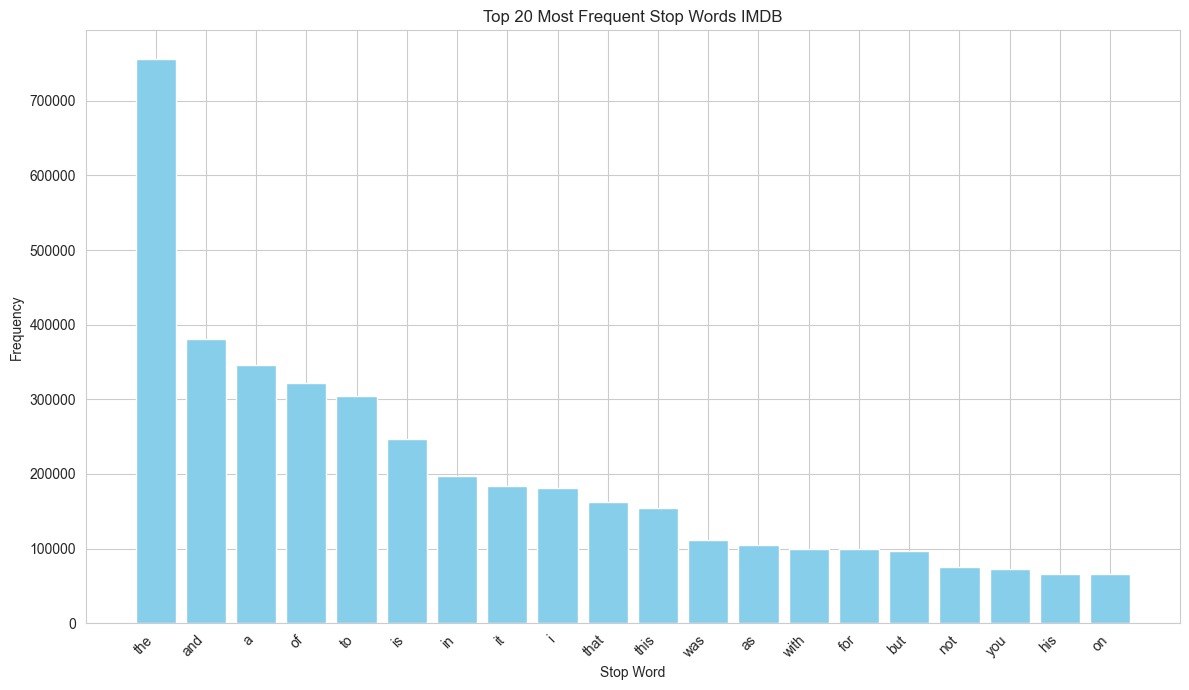

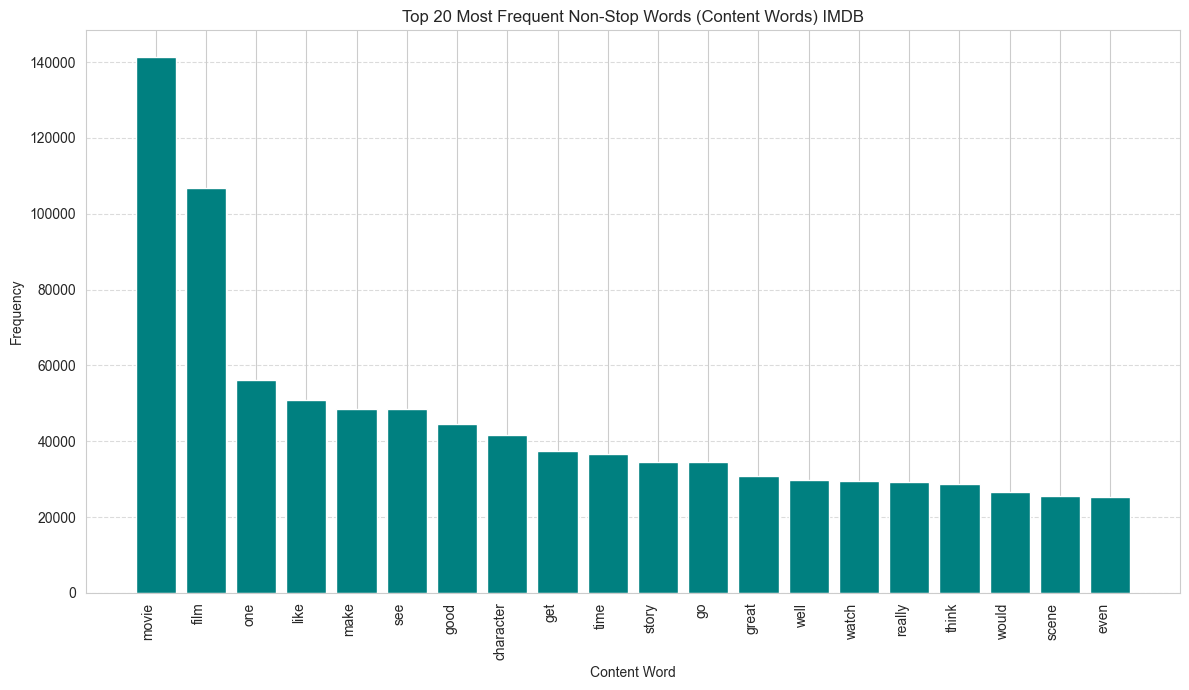

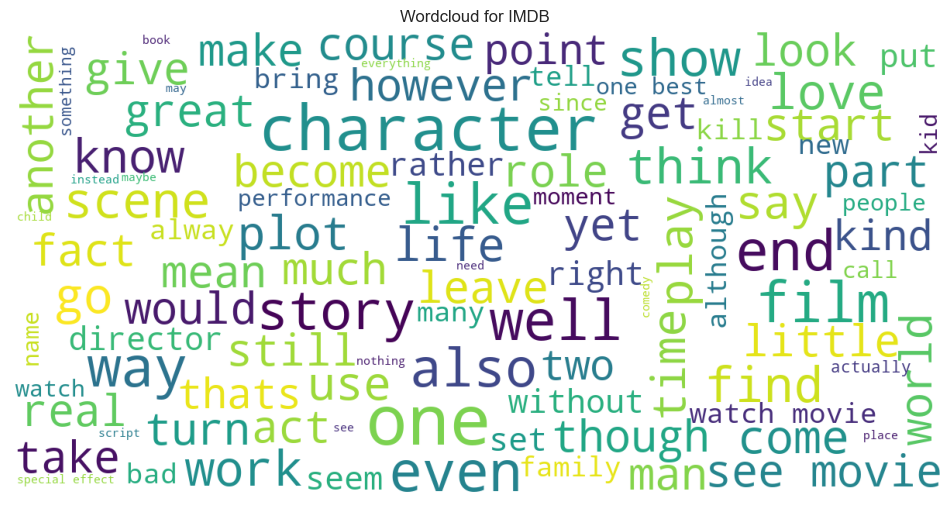

In [ ]:
imdb_df = do_eda(imdb_df, "review_text", "is_spoiler", "review_date", "IMDB")
# imdb_df.to_csv("./data/imdb_processed.csv", header=True, index=False)
imdb_df.to_pickle('./data/imdb_processed.pkl')

## goodreads

In [30]:
file_name_train = 'goodreads_balanced-train.json'
file_name_val = 'goodreads_balanced-val.json'
file_name_test = 'goodreads_balanced-test.json'
file_path = f'./data/'

train_goodreads_df = pd.read_json(file_path+file_name_train, lines=True)
val_goodreads_df = pd.read_json(file_path+file_name_val, lines=True)
test_goodreads_df = pd.read_json(file_path+file_name_test, lines=True)

goodreads_df = pd.concat(
    [train_goodreads_df, val_goodreads_df, test_goodreads_df],
    ignore_index=True
)
goodreads_df = goodreads_df.sample(frac=1, random_state=42)
goodreads_df = goodreads_df.reset_index(drop=True)
goodreads_df.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id,genres
0,181bcadf310864df7ab31df84878cb51,2012-06-01,"[[0, I really enjoyed this.], [0, I love the t...",4,False,2200877,79ee62e3f2ba299b813ba52b27063474,"{'fiction': 1238, 'romance': 501, 'fantasy, pa..."
1,86625310cfde768d201c263b78879c9f,2015-10-22,"[[0, Writing this review was difficult for me....",2,True,27211726,ffb14c9e783504bf122edde150de1ec1,"{'romance': 42, 'fiction': 12, 'fantasy, paran..."
2,ef2886db218b172157fd0fa428329fc1,2014-10-18,"[[0, Wow.], [0, Okay, I have to say I loved th...",5,True,13453029,290ba5162119f24959da42f7856395bb,"{'fiction': 968, 'fantasy, paranormal': 878, '..."
3,4a7f29e083865f9b9d973c1f1f8da3dc,2012-07-25,"[[0, If you have an extra hour or two to spare...",3,False,7940591,bdbef64e1f8547d2e53f432d1c91e2f4,"{'fiction': 331, 'mystery, thriller, crime': 9..."
4,4ad272c41af8a81a381278a7587d14a9,2014-07-19,"[[0, Wow.], [0, I am not sure how I feel about...",5,False,16109563,eb73c4efcba65a7a48a20aaa77bac2e9,"{'romance': 1002, 'fiction': 62, 'mystery, thr..."


In [31]:
goodreads_df["review_text"] = goodreads_df["review_sentences"].apply(
    lambda list_of_sentences: ' '.join([text for label, text in list_of_sentences])
)
goodreads_df.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id,genres,review_text
0,181bcadf310864df7ab31df84878cb51,2012-06-01,"[[0, I really enjoyed this.], [0, I love the t...",4,False,2200877,79ee62e3f2ba299b813ba52b27063474,"{'fiction': 1238, 'romance': 501, 'fantasy, pa...",I really enjoyed this. I love the touch of mag...
1,86625310cfde768d201c263b78879c9f,2015-10-22,"[[0, Writing this review was difficult for me....",2,True,27211726,ffb14c9e783504bf122edde150de1ec1,"{'romance': 42, 'fiction': 12, 'fantasy, paran...",Writing this review was difficult for me. It's...
2,ef2886db218b172157fd0fa428329fc1,2014-10-18,"[[0, Wow.], [0, Okay, I have to say I loved th...",5,True,13453029,290ba5162119f24959da42f7856395bb,"{'fiction': 968, 'fantasy, paranormal': 878, '...","Wow. Okay, I have to say I loved this book. I ..."
3,4a7f29e083865f9b9d973c1f1f8da3dc,2012-07-25,"[[0, If you have an extra hour or two to spare...",3,False,7940591,bdbef64e1f8547d2e53f432d1c91e2f4,"{'fiction': 331, 'mystery, thriller, crime': 9...",If you have an extra hour or two to spare and ...
4,4ad272c41af8a81a381278a7587d14a9,2014-07-19,"[[0, Wow.], [0, I am not sure how I feel about...",5,False,16109563,eb73c4efcba65a7a48a20aaa77bac2e9,"{'romance': 1002, 'fiction': 62, 'mystery, thr...",Wow. I am not sure how I feel about all of tho...


In [32]:
print("Dataframe shape before sampling: ", goodreads_df.shape)
goodreads_df = goodreads_df.sample(n=50_000, random_state=42)
print("Dataframe shape after sampling: ", goodreads_df.shape)


Dataframe shape before sampling:  (179254, 9)
Dataframe shape after sampling:  (50000, 9)


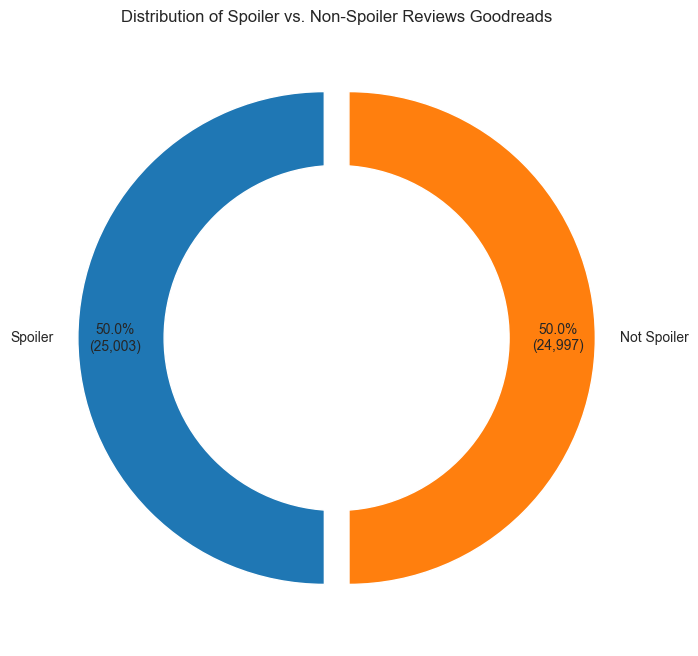

/var/folders/hr/ymtxctgs4jj0mr96r616g73r0000gp/T/ipykernel_7977/2590002882.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_counts = df.set_index(publishe_date_col).resample('M').size()


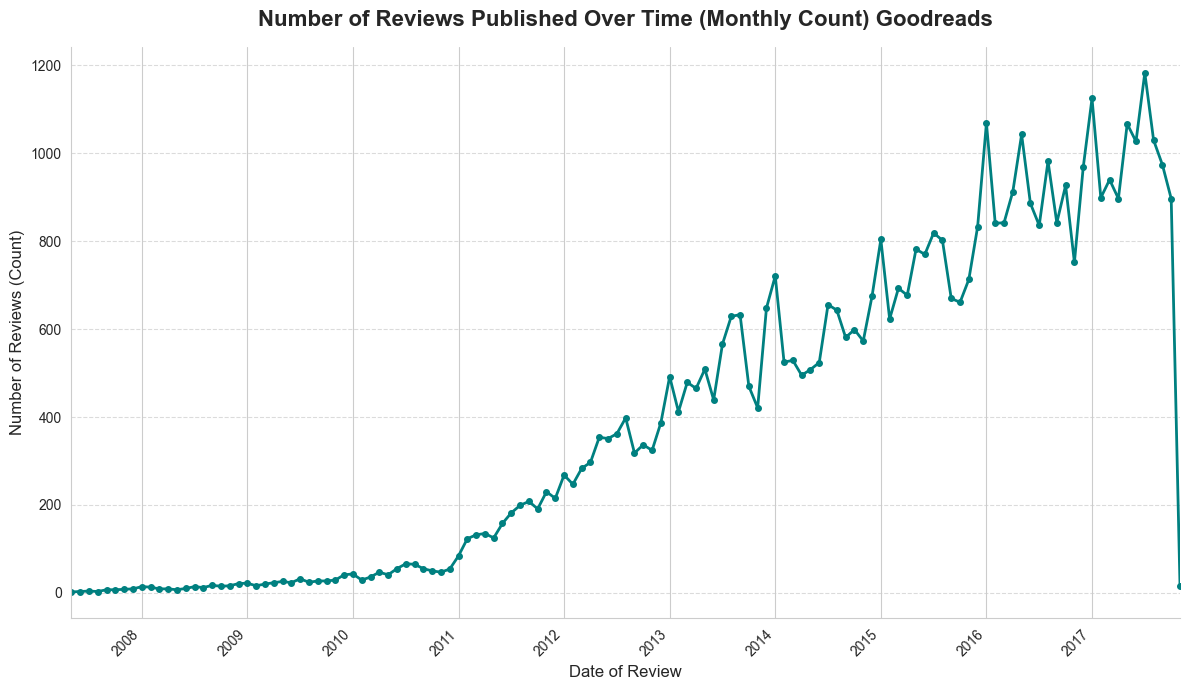

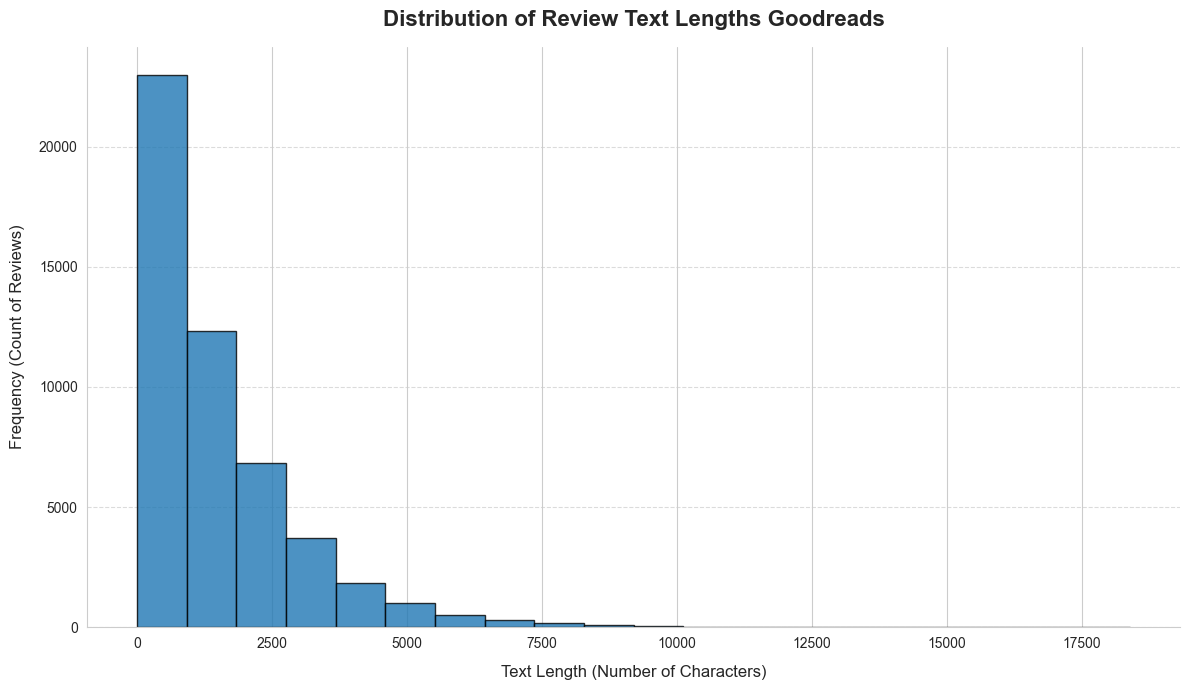

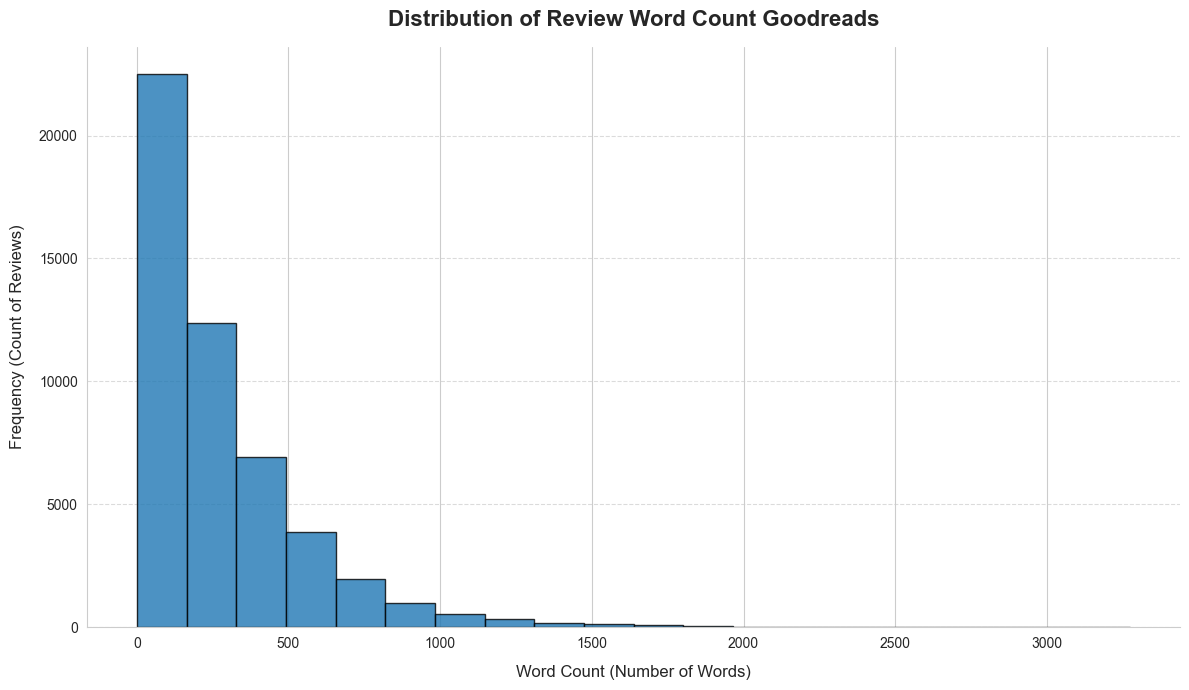

Total amount of words in df:  13624528
Transformed rows: 10000
Transformed rows: 20000
Transformed rows: 30000
Transformed rows: 40000
Transformed rows: 50000
Percentage of stopwords in reviews: 50.02%


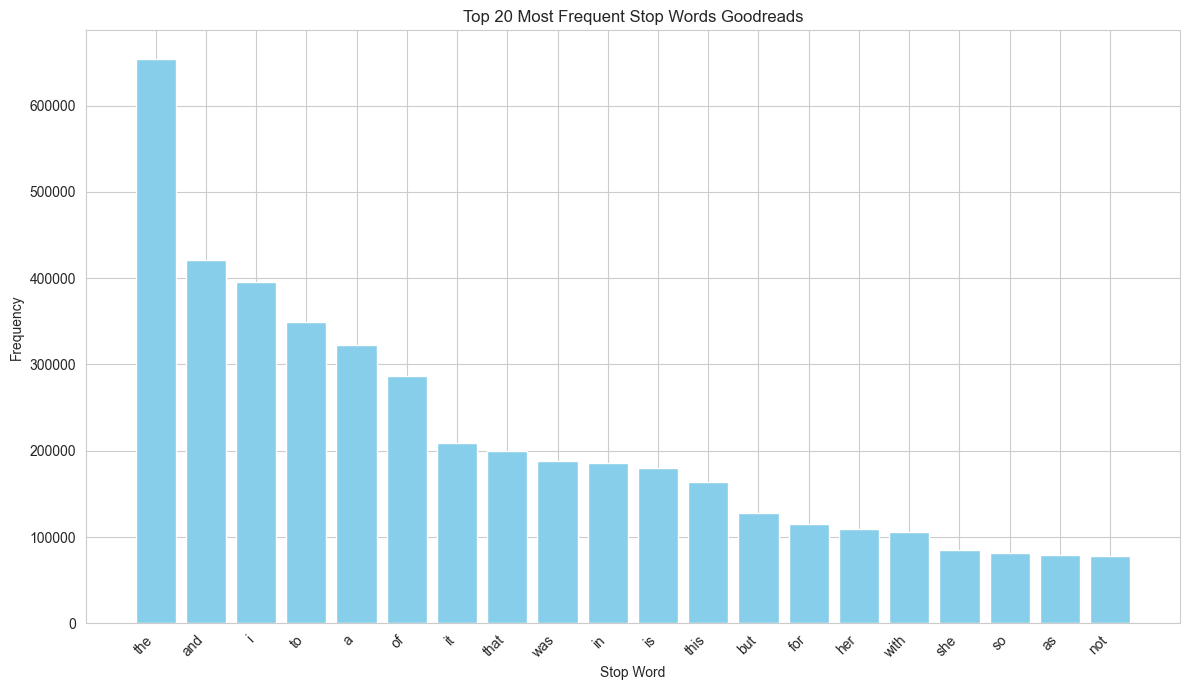

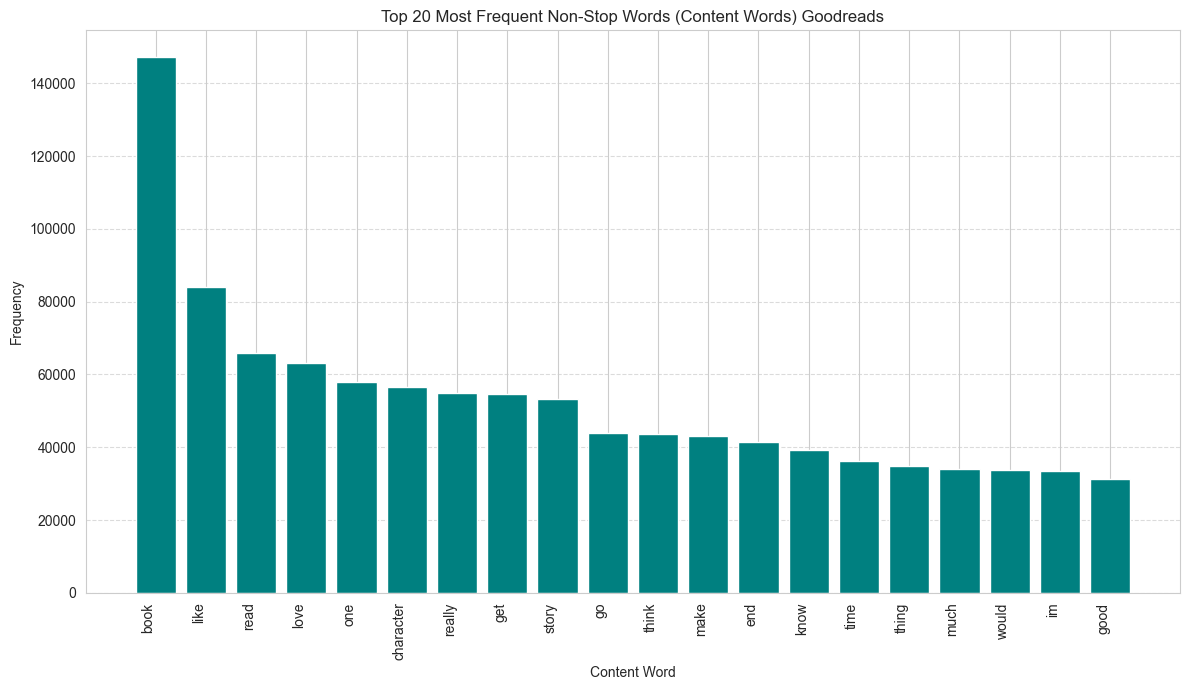

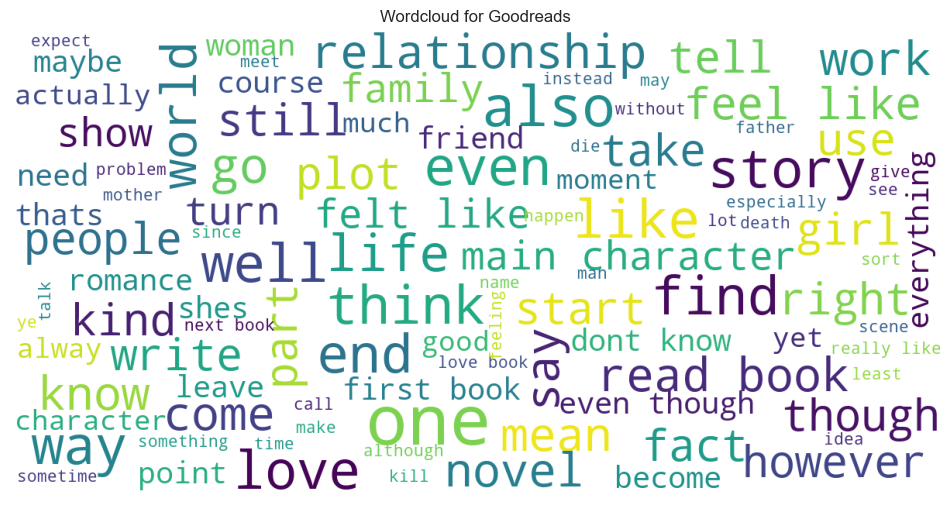

In [ ]:
goodreads_df = do_eda(goodreads_df, "review_text", "has_spoiler", "timestamp", "Goodreads")
# goodreads_df.to_csv("./data/goodreads_processed.csv", header=True, index=False)
goodreads_df.to_pickle('./data/goodreads_processed.pkl')

# Merged Datasets

In [20]:
def do_combined_eda(df, review_text_col, is_spoiler_col, publishe_date_col, df_name): 
    plot_donut(df, review_text_col, is_spoiler_col, df_name)
    plot_publishing_date(df, publishe_date_col, df_name)
    plot_text_distribution(df, review_text_col, is_spoiler_col, df_name)
    plot_word_distribution(df, review_text_col, is_spoiler_col, df_name)
    # df = punctuations_lower_tokenize_dataframe(df, review_text_col, is_spoiler_col, df_name)
    # df = stopwords_lemmatization(df)
    plot_stopwords(df, df_name)
    all_content_words = df['content_words'].explode().tolist()    
    all_content_words = [word for word in all_content_words if isinstance(word, str)]

    plot_content_words(all_content_words, df_name)
    plot_wordcloud(all_content_words, df_name)
    return df

In [36]:
print(type(imdb_df['stops'].iloc[0]))
imdb_df.to_pickle('imdb_df.pkl')

<class 'list'>


In [39]:
imdb_read_df = pd.read_pickle("data/imdb_processed.pkl")
goodreads_read_df = pd.read_pickle("data/goodreads_processed.pkl")

imdb_cols = ["review_text", "is_spoiler", "content_words", "review_date", "punctuations_lower_tokenize", 'stops',
       'stopword_count', 'total_word_count']
goodreads_cols = ["review_text", "has_spoiler", "content_words", "timestamp", "punctuations_lower_tokenize", 'stops',
       'stopword_count', 'total_word_count']

df_imdb_subset = imdb_read_df[imdb_cols].copy()

df_gr_subset = goodreads_read_df[goodreads_cols].copy()
df_gr_subset = df_gr_subset.rename(columns={"has_spoiler": "is_spoiler", "timestamp":"review_date"})

df_imdb_subset['source'] = 'imdb'
df_gr_subset['source'] = 'goodreads'

combined_df = pd.concat([df_imdb_subset, df_gr_subset], axis=0, ignore_index=True)

print(f"IMDB shape: {df_imdb_subset.shape}")
print(f"Goodreads shape: {df_gr_subset.shape}")
print(f"Combined shape: {combined_df.shape}")
print("\nFirst 5 rows:")
combined_df.head()

IMDB shape: (50000, 9)
Goodreads shape: (50000, 9)
Combined shape: (100000, 9)

First 5 rows:


,review_text,is_spoiler,content_words,review_date,punctuations_lower_tokenize,stops,stopword_count,total_word_count,source
0,I really enjoyed the movie and now it's great ...,False,"[really, enjoy, movie, great, able, see, behin...",2001-01-19,"[i, really, enjoyed, the, movie, and, now, its...","[i, the, and, now, its, to, be, all, the, the,...",20,40,imdb
1,I never leave out animated movies that comes o...,False,"[never, leave, animated, movie, come, hollywoo...",2009-01-10,"[i, never, leave, out, animated, movies, that,...","[i, out, that, out, from, the, this, was, out,...",102,198,imdb
2,This show combines two of my favorite Netflix ...,False,"[show, combine, two, favorite, netflix, origin...",2017-12-04,"[this, show, combines, two, of, my, favorite, ...","[this, of, my, and, the, i, that, is, a, in, a...",33,69,imdb
3,"I really tried to like this movie. I mean, goo...",False,"[really, try, like, movie, mean, good, actor, ...",2013-11-13,"[i, really, tried, to, like, this, movie, i, m...","[i, to, this, i, some, the, is, that, the, who...",89,184,imdb
4,*** This comment may contain spoilers ***I'd s...,False,"[comment, may, contain, spoiler, id, see, come...",2008-01-09,"[this, comment, may, contain, spoilers, id, se...","[this, this, when, it, out, in, and, had, not,...",86,195,imdb


In [41]:
combined_df.to_pickle('./data/combined_df.pkl')

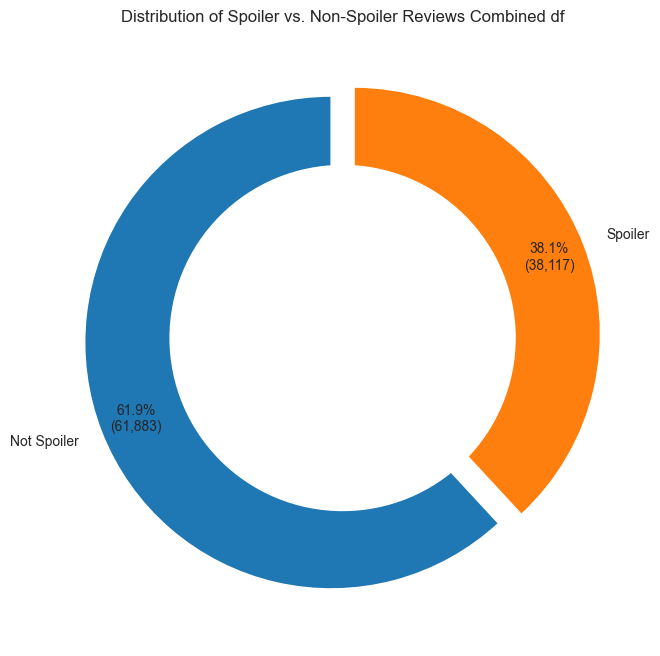

/var/folders/hr/ymtxctgs4jj0mr96r616g73r0000gp/T/ipykernel_7977/2590002882.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  review_counts = df.set_index(publishe_date_col).resample('M').size()


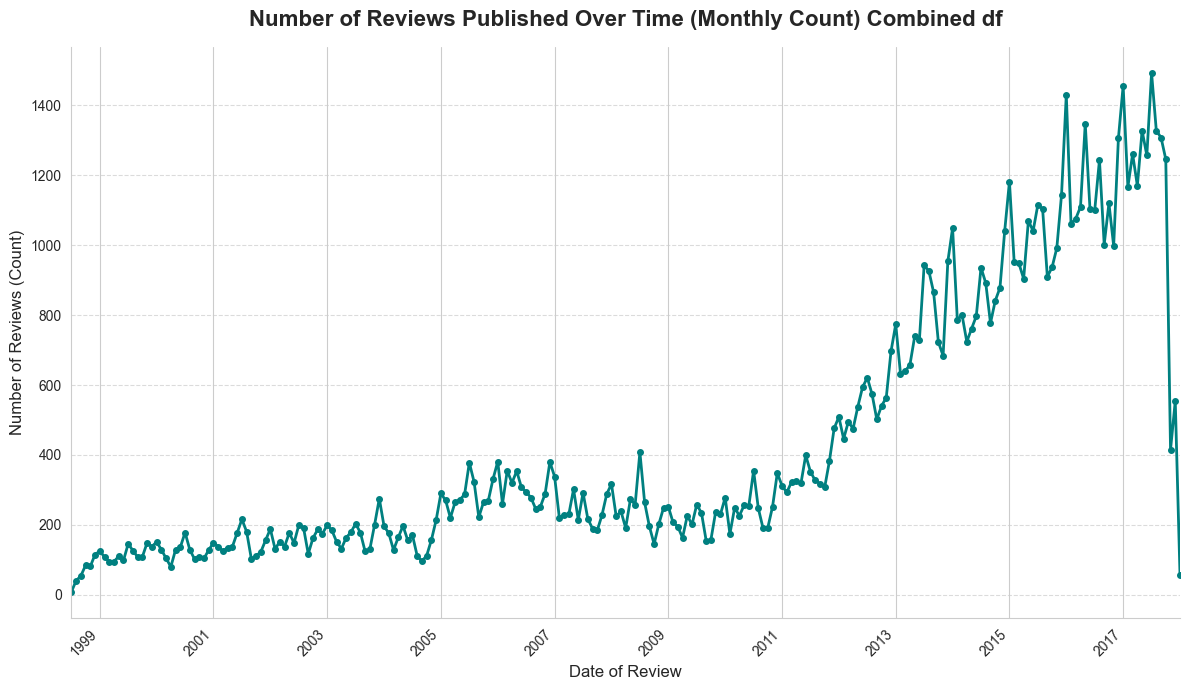

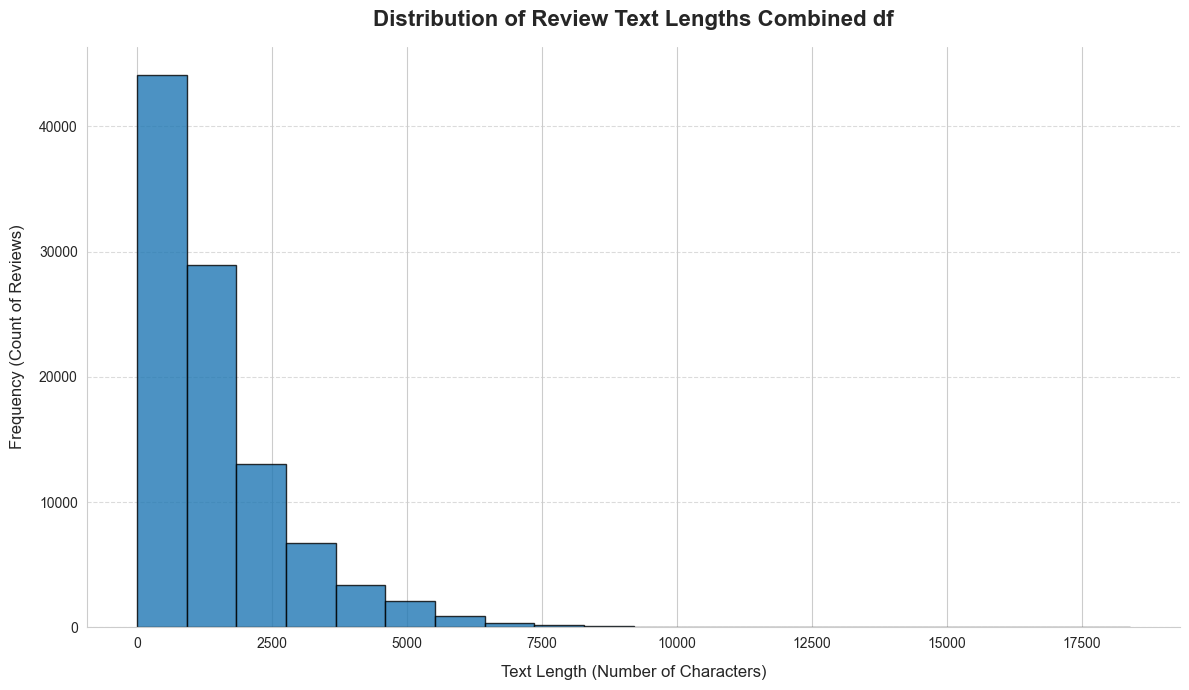

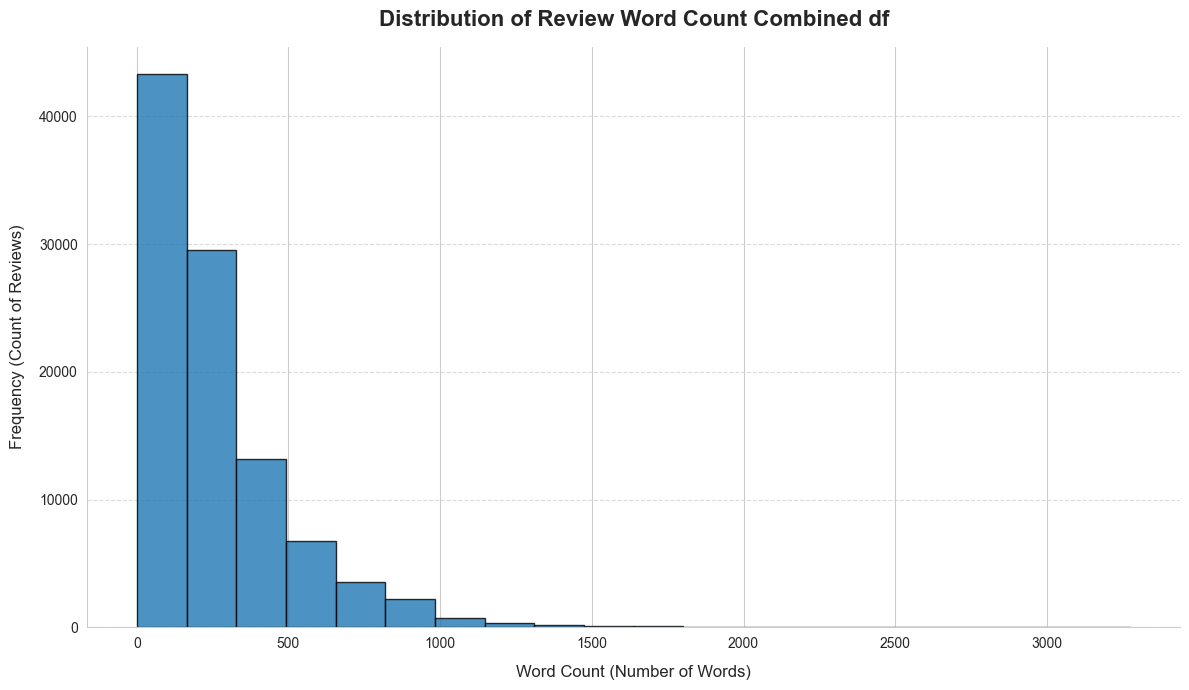

Total amount of words in df:  26529007
Percentage of stopwords in reviews: 48.80%


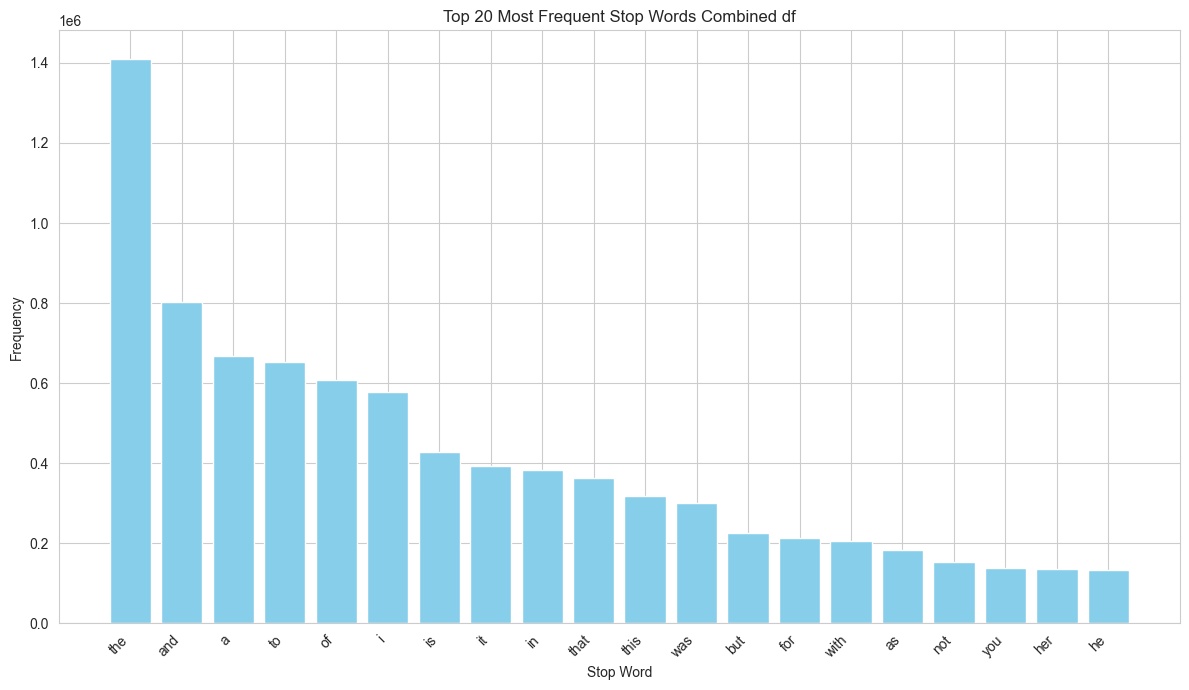

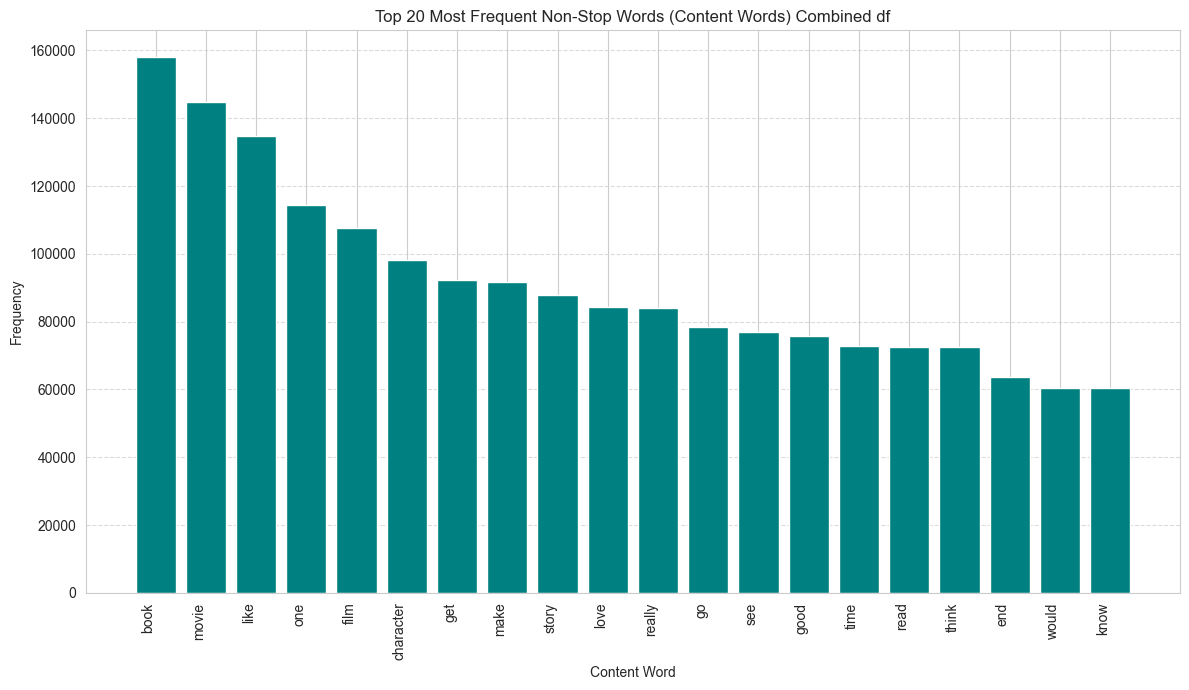

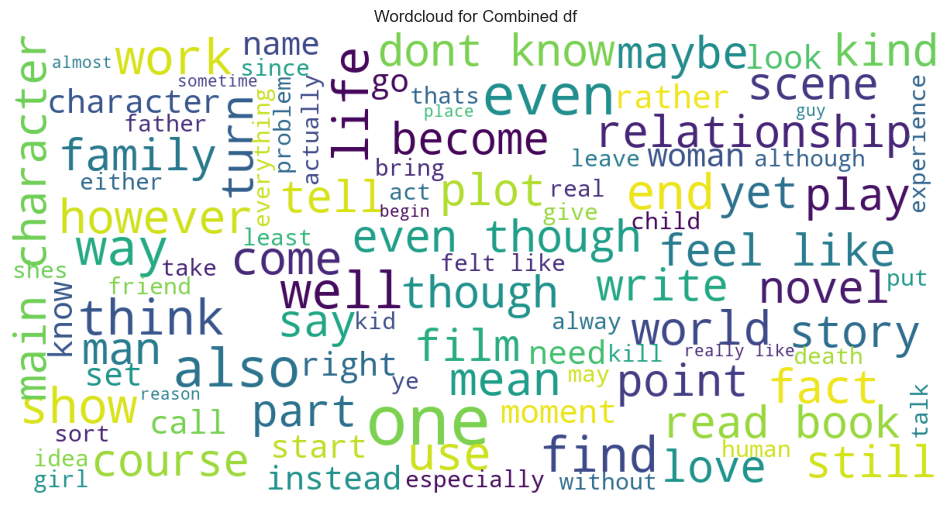

In [40]:
do_combined_eda(combined_df, "review_text", "is_spoiler", "review_date", "Combined df")
# combined_df.to_csv("./data/combined_df.csv", header=True, index=False)
combined_df.to_pickle('./data/combined_df.pkl')